In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler,PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from datetime import datetime, date
from matplotlib import pylab
from SoftSVM import SoftSVM
from prepare import prepare_data
params = {'xtick.labelsize': 18,
 'ytick.labelsize': 18,
 'axes.titlesize' : 22,
 'axes.labelsize' : 20,
 'legend.fontsize': 18,
 'legend.title_fontsize': 22,
 'figure.titlesize': 24
 }
pylab.rcParams.update(params)

visualize_clf:

In [2]:
def visualize_clf(clf, X, Y, title, 
                  xlabel, ylabel,
                  marker_size=50,
                  grid_length=300,
                  linewidths=None):
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap
    
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
        
    # For internal use here, make sure labels are 0 and 1
    Y = np.ravel(Y).astype(int)
    labels = set(Y)
    assert len(labels) == 2, "Can only visualize two unique labels"

    if labels == set([-1,1]):
      Y = (Y + 1) // 2
      labels = set(Y)
    
    assert labels == set([0,1]), "Could not handle given labels"

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["D", "o"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(labels, palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size,
                    linewidths=linewidths)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()
   

Data Loading

In [3]:
df = pd.read_csv('virus_data.csv')


In [4]:
training_df, test_df = train_test_split(df , train_size= 0.8, random_state = 72)


In [7]:
training_df_cleaned = prepare_data(training_df , training_df)
test_df_cleaned = prepare_data(training_df, test_df)

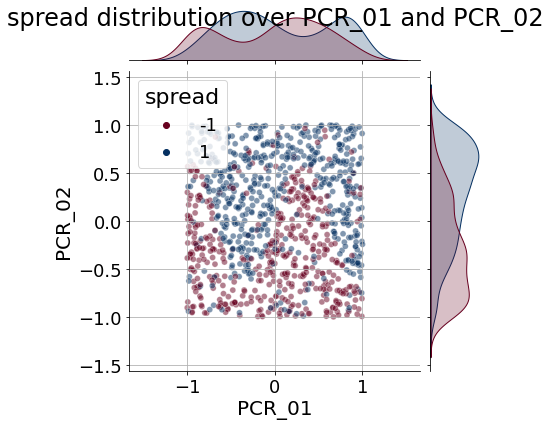

In [8]:
# Q(1)
temp_df = training_df_cleaned[['PCR_01','PCR_02','spread']]
g = sns.jointplot(data= temp_df, x='PCR_01',y='PCR_02' , hue='spread', palette='RdBu', alpha=0.5)
g.ax_joint.grid(True)
g.fig.suptitle("spread distribution over PCR_01 and PCR_02")
plt.show()


In [9]:
#Q(2)
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(np.array(temp_df[['PCR_01','PCR_02']]) , np.array(temp_df['spread']))

KNeighborsClassifier(n_neighbors=1)

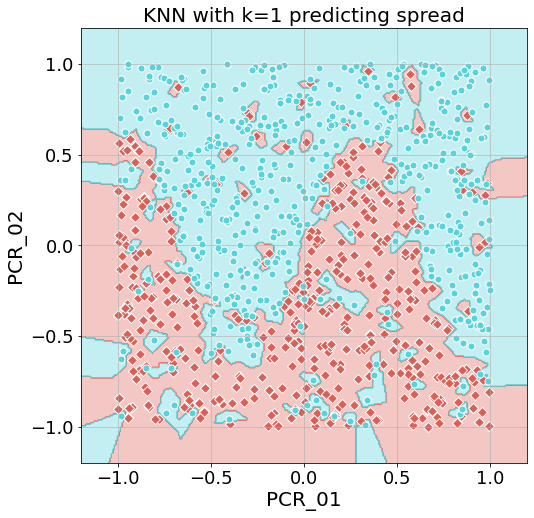

In [10]:
visualize_clf(knn, np.array(temp_df[['PCR_01','PCR_02']]), temp_df['spread'], 'KNN with k=1 predicting spread', 'PCR_01', 'PCR_02')

In [11]:
#Q(3)
list_of_k = list(range(1,20,2)) + list(range(20,871,85))
k_folds = 8
k_values_score_validation = np.zeros(len(list_of_k))
k_values_score_train = np.zeros(len(list_of_k))

In [12]:
for i in range(len(list_of_k)):
  temp_knn = KNeighborsClassifier(n_neighbors=list_of_k[i])
  temp_cv_results = cross_validate(temp_knn, np.array(training_df_cleaned[['PCR_01', 'PCR_02']]),training_df_cleaned['spread'],return_train_score=True , cv=k_folds)
  k_values_score_validation[i] = temp_cv_results['test_score'].mean()
  k_values_score_train[i]  = temp_cv_results['train_score'].mean()

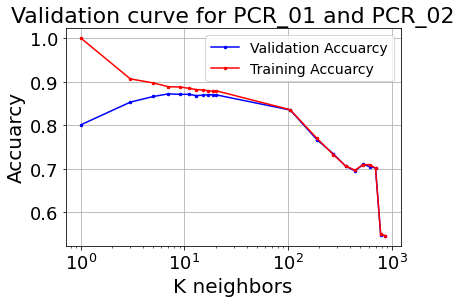

In [13]:
plt.semilogx(list_of_k, k_values_score_validation, marker = ".",
             markersize = 5, color = "blue", label = "Validation Accuarcy")

plt.semilogx(list_of_k, k_values_score_train, marker = ".",
             markersize = 5, color = "red", label = "Training Accuarcy")

plt.grid()
plt.title('Validation curve for PCR_01 and PCR_02')
plt.ylabel('Accuarcy')
plt.xlabel('K neighbors')
plt.legend( prop={'size': 14})
plt.show()

In [14]:
#Q4
optimal_k = list_of_k[np.argmax(k_values_score_validation)]
knn_optimal_k = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal_k.fit(np.array(temp_df[['PCR_01','PCR_02']]) , temp_df['spread'])


KNeighborsClassifier(n_neighbors=7)

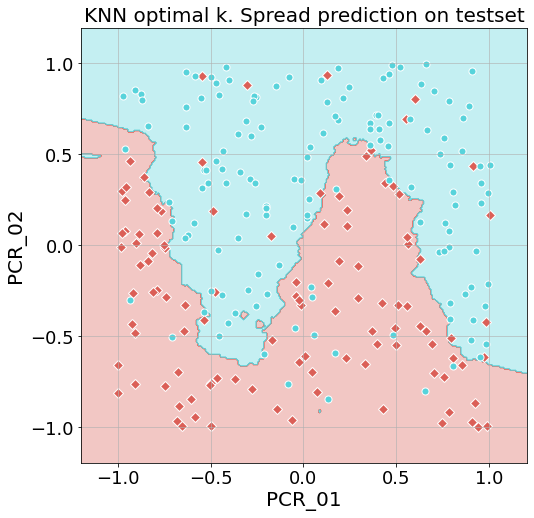

In [15]:
visualize_clf(knn_optimal_k, np.array(test_df_cleaned[['PCR_01','PCR_02']]), test_df_cleaned['spread'], 'KNN optimal k. Spread prediction on testset', 'PCR_01','PCR_02' )


In [16]:

knn_optimal_k.score(np.array(test_df_cleaned[['PCR_01','PCR_02']]), test_df_cleaned['spread'])

0.856

In [17]:
#Q5
knn_1 = KNeighborsClassifier(n_neighbors=1)
knn_1.fit(np.array(temp_df[['PCR_01','PCR_02']]) , temp_df['spread'])

KNeighborsClassifier(n_neighbors=1)

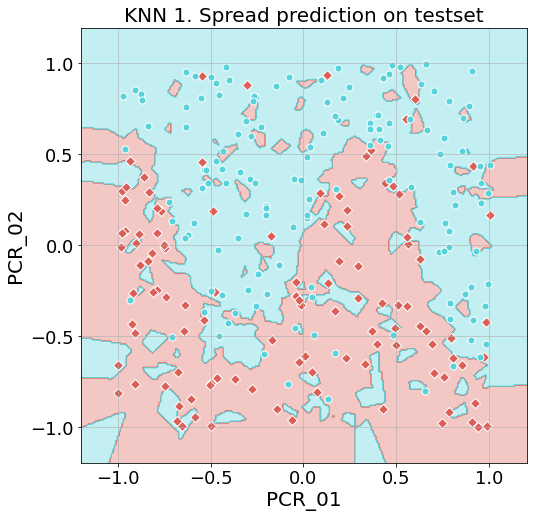

In [18]:
visualize_clf(knn_1, np.array(test_df_cleaned[['PCR_01','PCR_02']]), test_df_cleaned['spread'], 'KNN 1. Spread prediction on testset', 'PCR_01','PCR_02' )


In [19]:
knn_1.score(np.array(test_df_cleaned[['PCR_01','PCR_02']]), test_df_cleaned['spread'])

0.796

In [20]:
knn_501 = KNeighborsClassifier(n_neighbors=501)
knn_501.fit(np.array(temp_df[['PCR_01','PCR_02']]) , temp_df['spread'])

KNeighborsClassifier(n_neighbors=501)

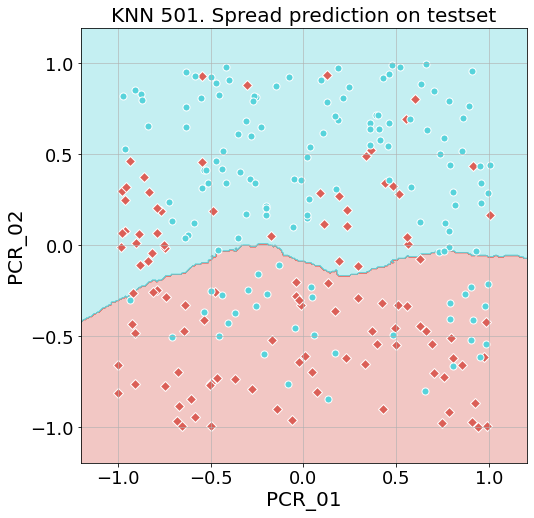

In [21]:
visualize_clf(knn_501, np.array(test_df_cleaned[['PCR_01','PCR_02']]), test_df_cleaned['spread'], 'KNN 501. Spread prediction on testset', 'PCR_01','PCR_02' )


In [22]:
knn_501.score(np.array(test_df_cleaned[['PCR_01','PCR_02']]), test_df_cleaned['spread'])

0.688

In [23]:
#Q6
list_of_k = list(range(1,20,2)) + list(range(20,871,85))
k_folds = 8
k_values_score_validation = np.zeros(len(list_of_k))
k_values_score_train = np.zeros(len(list_of_k))

In [25]:
training_df_all_features = training_df_cleaned.drop(['spread','risk'], axis=1).copy()
for i in range(len(list_of_k)):
  temp_knn = KNeighborsClassifier(n_neighbors=list_of_k[i])
  temp_cv_results = cross_validate(temp_knn, np.array(training_df_all_features),training_df_cleaned['spread'],return_train_score=True , cv=k_folds)
  k_values_score_validation[i] = temp_cv_results['test_score'].mean()
  k_values_score_train[i]  = temp_cv_results['train_score'].mean()

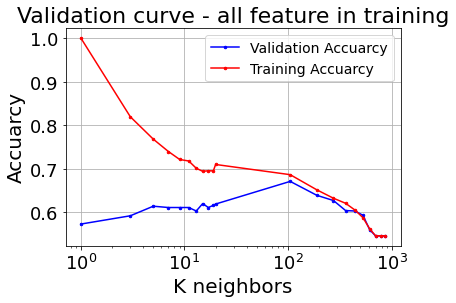

In [26]:
plt.semilogx(list_of_k, k_values_score_validation, marker = ".",
             markersize = 5, color = "blue", label = "Validation Accuarcy")

plt.semilogx(list_of_k, k_values_score_train, marker = ".",
             markersize = 5, color = "red", label = "Training Accuarcy")

plt.grid()
plt.title('Validation curve - all feature in training')
plt.ylabel('Accuarcy')
plt.xlabel('K neighbors')
plt.legend( prop={'size': 14})
plt.show()

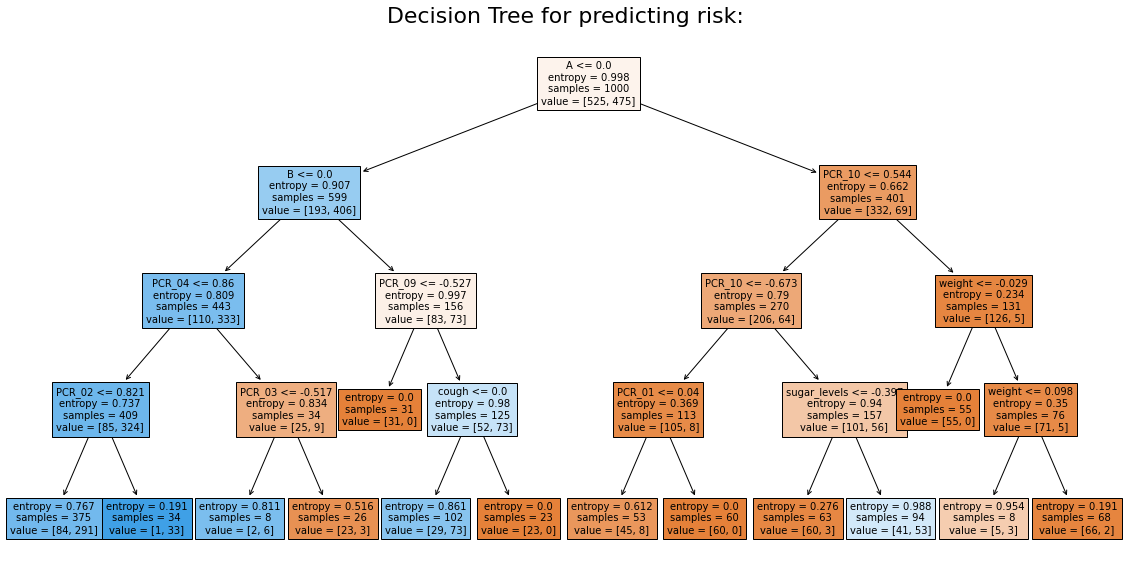

In [27]:
#Q7-Print Decistion Tree
dt=DecisionTreeClassifier(criterion='entropy',max_depth=4)
dt.fit(training_df_all_features,training_df_cleaned['risk'])
plt.figure(figsize=(20, 10))
tree.plot_tree(dt, filled=True,feature_names=training_df_all_features.columns,fontsize=10)
plt.title('Decision Tree for predicting risk:')
plt.grid()
plt.show()

In [28]:
#Q7 - Calculate Accuracy of Decison Tree
test_df_all_features = test_df_cleaned.drop(['spread','risk'], axis=1).copy()
dt.score(test_df_all_features,test_df_cleaned['risk'])

0.78

In [29]:
#Q8 - Model Selection
max_depth = list(range(12, 3, -1))
min_samples_leaf = list(range(4, 16, 1))
parameters = {'max_depth':max_depth, 'min_samples_leaf': min_samples_leaf}
dt = DecisionTreeClassifier(criterion='entropy')
grid_dt = GridSearchCV(dt, parameters,return_train_score=True,cv=8)
grid_dt.fit(training_df_all_features, training_df_cleaned['risk'])

validation_scores = grid_dt.cv_results_['mean_test_score'].reshape(len(max_depth),len(min_samples_leaf))
training_scores = grid_dt.cv_results_['mean_train_score'].reshape(len(max_depth),len(min_samples_leaf))

Text(0.5, 1.0, 'Mean validation accuracy')

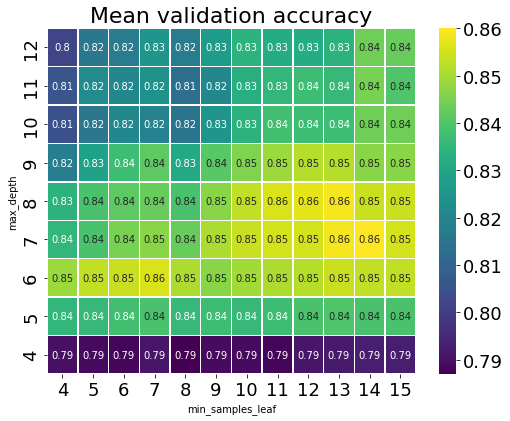

In [30]:
plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
p = sns.heatmap(validation_scores, cmap='viridis', annot = True, xticklabels = min_samples_leaf, yticklabels = max_depth,linewidths=.5)
p.set_xlabel("min_samples_leaf", fontsize = 10)
p.set_ylabel("max_depth", fontsize = 10)
plt.title('Mean validation accuracy')


Text(0.5, 1.0, 'Mean training accuracy')

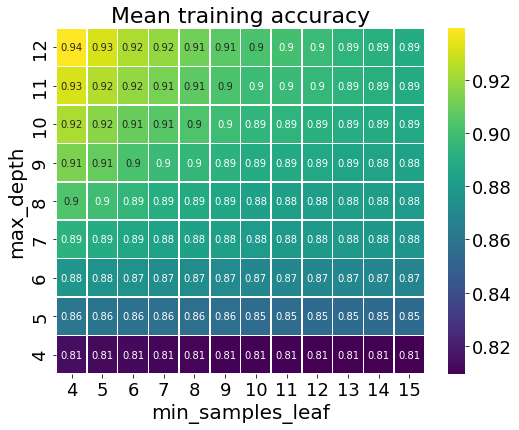

In [31]:
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
p = sns.heatmap(training_scores,cmap="viridis", annot = True, xticklabels = min_samples_leaf, yticklabels = max_depth,linewidths=.5)
p.set_xlabel("min_samples_leaf", fontsize = 20)
p.set_ylabel("max_depth", fontsize = 20)
plt.title('Mean training accuracy')

In [32]:
dt_opt = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf = 7)
dt_opt.fit(training_df_all_features,training_df_cleaned['risk'])
dt_opt.score(test_df_all_features,test_df_cleaned['risk'])


0.828

In [33]:
def numerical_subgradient(w, b, C, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = SoftSVM.loss(w_, b, C, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = SoftSVM.loss(w_, b, C, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (SoftSVM.loss(w_, b + delta, C, X, y) - orig_objective) / delta
    return g_w, g_b



def compare_gradients(X, y, deltas, C=1, REPEATS=100, figsize=(10, 6)):
    residual_means = []

    for delta in deltas:
        residuals = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad = SoftSVM.subgradient(w, b, C, X, y)[0]
            numeric_grad = numerical_subgradient(w, b, C, X, y, delta=delta)[0]

            residual = np.linalg.norm(numeric_grad - analytic_grad)
            residuals.append(residual)

        residual_means.append(np.mean(residuals))

    plt.figure(figsize=figsize)
    plt.title('Residuals of analytical and numerical gradients', fontsize=22)
    plt.plot(deltas, residual_means, linewidth=3)      
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\delta$', fontsize=18)
    plt.ylabel(r'$\left\Vert \nabla_{w}p_{C}\left(w,b\right) - u_{\delta} \left(w,b\right)\right\Vert$', fontsize=18)

    plt.grid(alpha=0.5)
    plt.show()


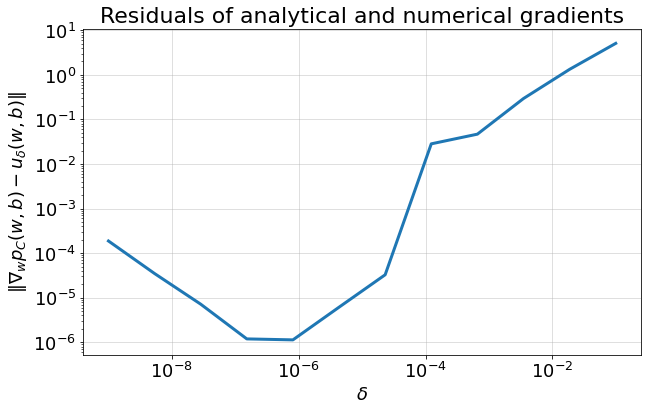

In [34]:
#Part 4
#Q(10)
X_train = np.array(training_df_cleaned[['PCR_01','PCR_02']])
y_train = np.array(training_df_cleaned['spread'])
X_test = np.array(test_df_cleaned[['PCR_01','PCR_02']])
y_test = np.array(test_df_cleaned['spread'])
compare_gradients(X_train, y_train, deltas=np.logspace(-9, -1, 12))

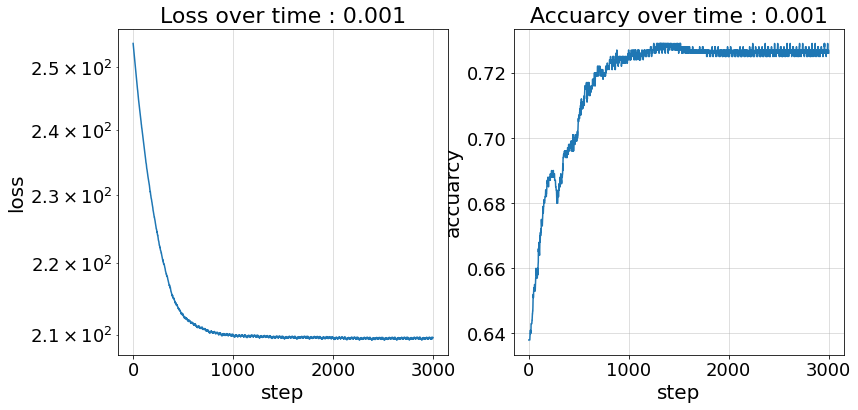

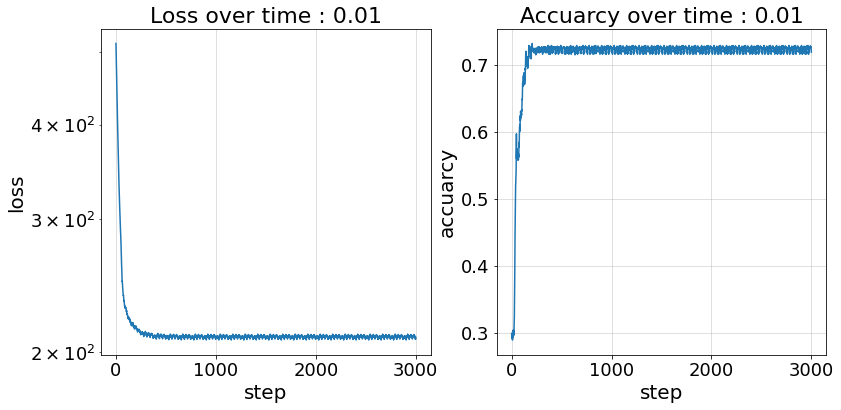

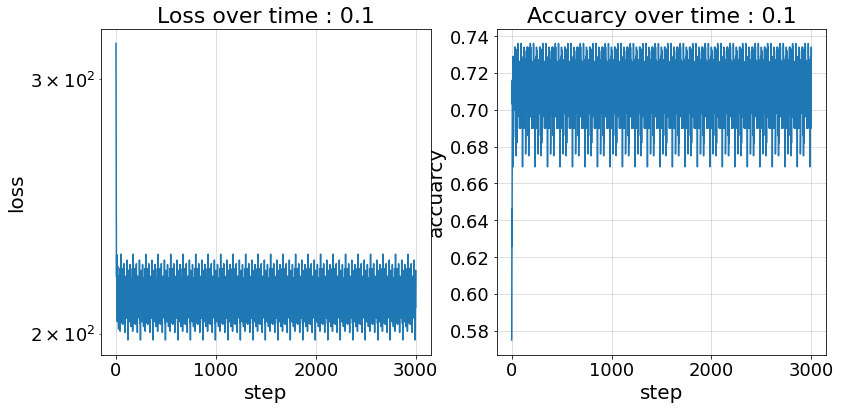

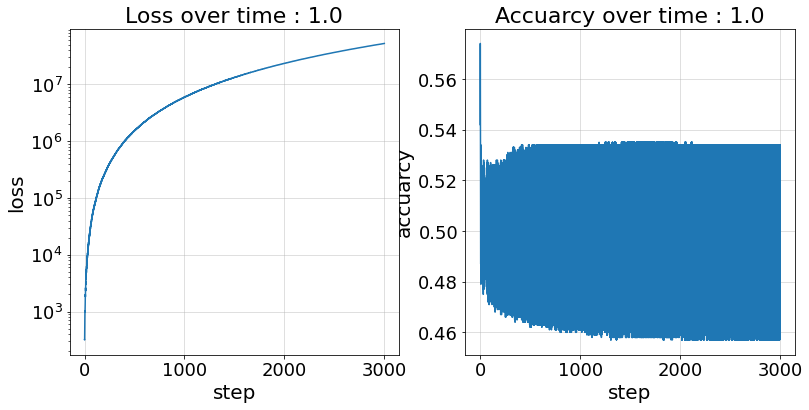

In [35]:
#Q(11) A

for i in np.logspace(-3, 0, 4):
  clf = SoftSVM(C=0.3, lr=i)
  losses, accuracies = clf.fit_with_logs(X_train, y_train, max_iter=3000)
  plt.figure(figsize=(13, 6))
  plt.subplot(121), plt.grid(alpha=0.5), plt.title ("Loss over time : " +str(i))
  plt.semilogy(losses), plt.xlabel("step"), plt.ylabel("loss")
  plt.subplot(122), plt.grid(alpha=0.5), plt.title ("Accuarcy over time : " + str(i))
  plt.plot(accuracies), plt.xlabel("step"), plt.ylabel("accuarcy")


0.725


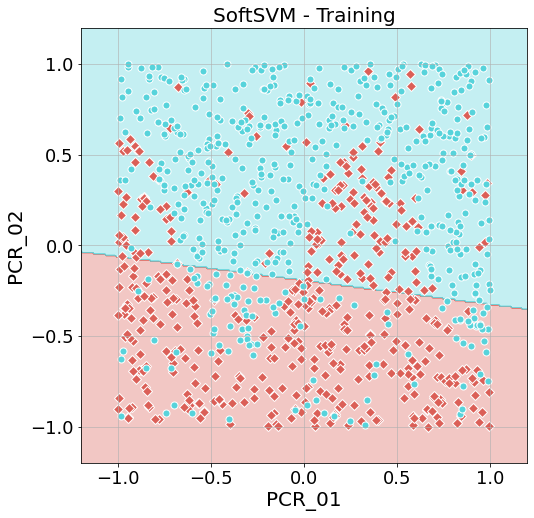

In [36]:
#Q(11) B
clf = SoftSVM(C=0.3, lr=0.01)
losses, accuracies = clf.fit_with_logs(X_train, y_train, max_iter=3000)
print(clf.score(X_train , y_train))
visualize_clf(clf, X_train, y_train, 'SoftSVM - Training', 'PCR_01','PCR_02' )


In [37]:
# Q(11) C
print(np.max(accuracies))
print(np.argmax(accuracies))
print(np.min(losses))
print(np.argmin(losses))

0.73
134
206.97023443634208
1988


Train Accuarcy: 0.734
Test Accuarcy: 0.72


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


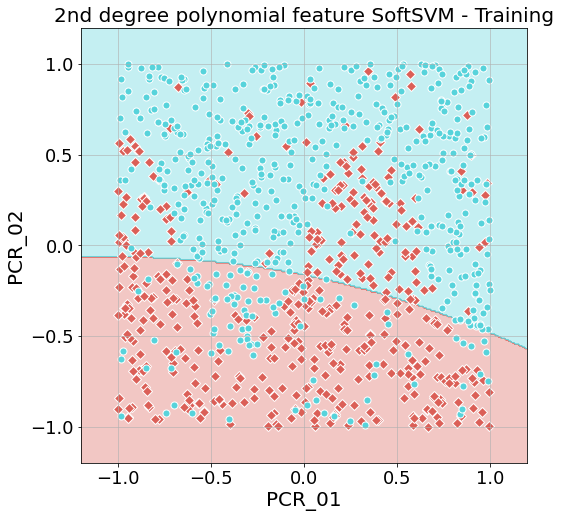

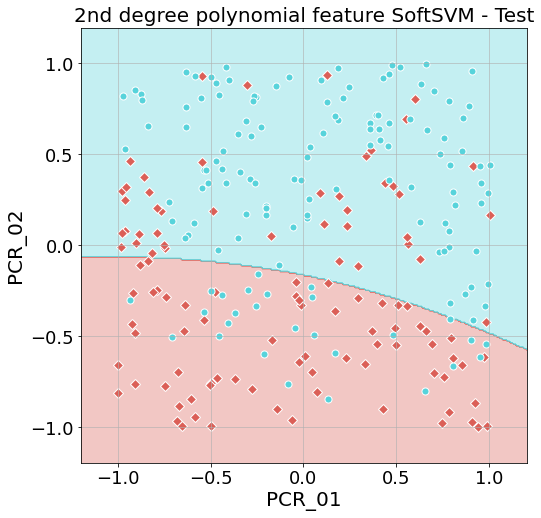

In [38]:
#Q(12)
C = 1e13
from sklearn.preprocessing import StandardScaler
svm_clf = Pipeline([('feature_mapping', PolynomialFeatures(2)), ('scaler', StandardScaler()), ('SVM', SoftSVM(C=C, lr=(1/(C*5e2))))])
svm_clf.fit(X_train,y_train, SVM__max_iter = 10000)
print("Train Accuarcy: " + str(svm_clf.score(X_train,y_train)))
print("Test Accuarcy: " + str(svm_clf.score(test_df_cleaned[['PCR_01' , 'PCR_02']],test_df_cleaned['spread'])))
visualize_clf(svm_clf, X_train, y_train, '2nd degree polynomial feature SoftSVM - Training', 'PCR_01','PCR_02' )
visualize_clf(svm_clf, X_test, y_test, '2nd degree polynomial feature SoftSVM - Test', 'PCR_01','PCR_02' )



Train Accuarcy: 0.85
Test Accuarcy: 0.824


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


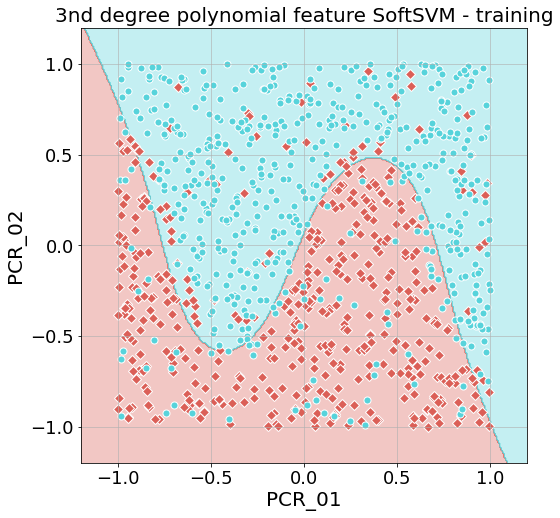

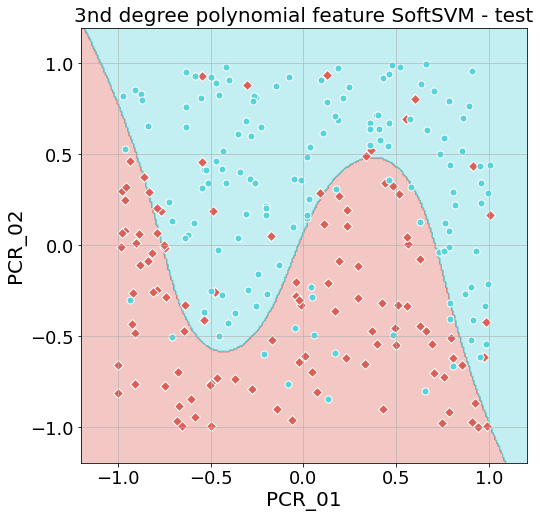

In [39]:
svm_clf = Pipeline([('feature_mapping', PolynomialFeatures(3)), ('scaler', StandardScaler()), ('SVM', SoftSVM(C=C, lr=(1/(C*5e2))))])
svm_clf.fit(X_train,y_train, SVM__max_iter = 10000)
print("Train Accuarcy: " + str(svm_clf.score(X_train,y_train)))
print("Test Accuarcy: " + str(svm_clf.score(test_df_cleaned[['PCR_01' , 'PCR_02']],test_df_cleaned['spread'])))
visualize_clf(svm_clf, X_train, y_train, '3nd degree polynomial feature SoftSVM - training', 'PCR_01','PCR_02' )
visualize_clf(svm_clf, X_test, y_test, '3nd degree polynomial feature SoftSVM - test', 'PCR_01','PCR_02' )


Train Accuarcy: 0.849


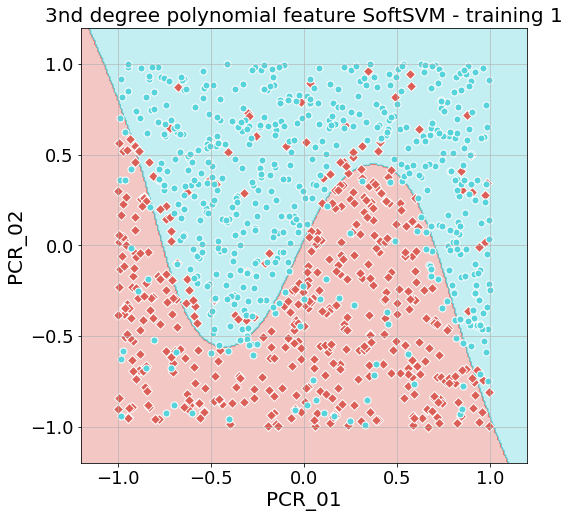

Train Accuarcy: 0.851


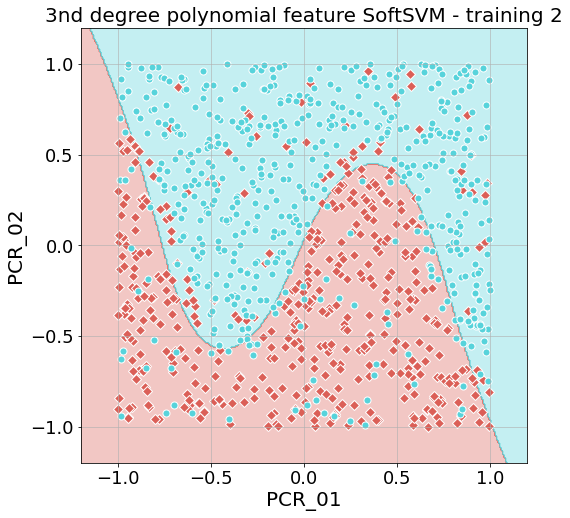

Train Accuarcy: 0.85


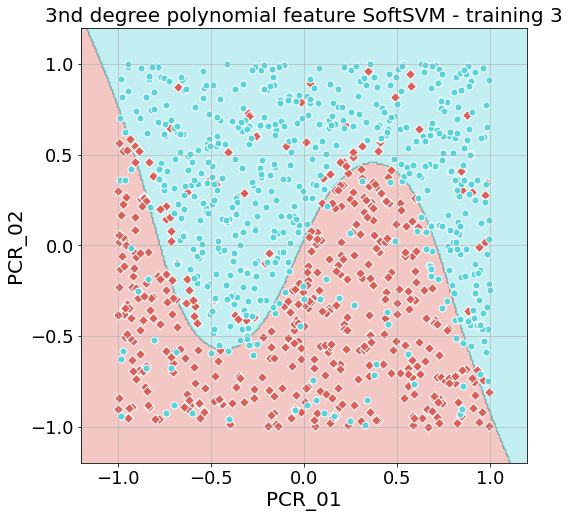

Train Accuarcy: 0.851


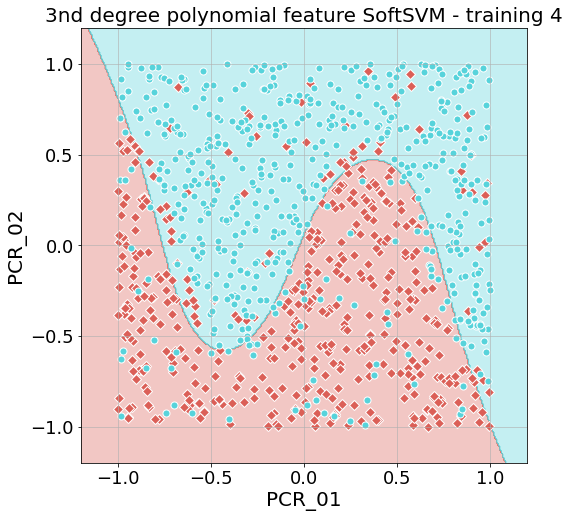

Train Accuarcy: 0.845


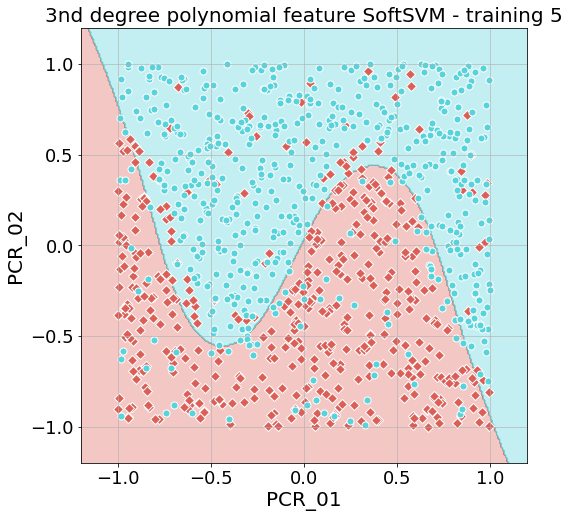

mean: 0.8492
std: 0.002227105745132011


In [40]:
#Q(13)
accuarcies =[]
for i in range(1,6,1):
  svm_clf = Pipeline([('feature_mapping', PolynomialFeatures(3)), ('scaler', StandardScaler()), ('SVM', SoftSVM(C=C, lr=(1/(C*5e2))))])
  svm_clf.fit(X_train,y_train, SVM__max_iter = 10000)
  print("Train Accuarcy: " + str(svm_clf.score(X_train,y_train)))
  visualize_clf(svm_clf, X_train, y_train, '3nd degree polynomial feature SoftSVM - training '+str(i), 'PCR_01','PCR_02' )
  accuarcies.append(svm_clf.score(X_train,y_train))

print('mean: ' + str(np.array(accuarcies).mean()))
print('std: ' + str(np.array(accuarcies).std()))


In [81]:
# PART 4


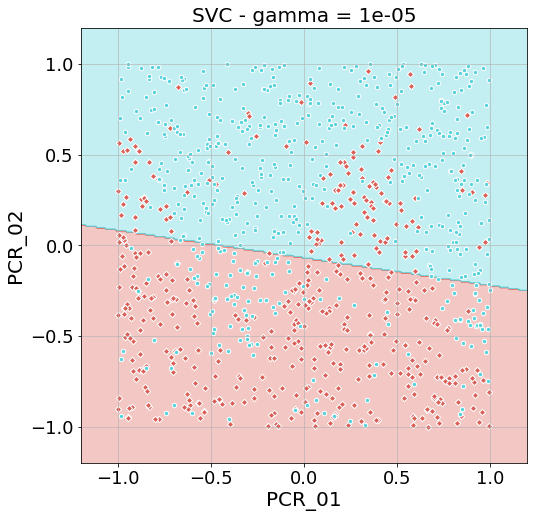

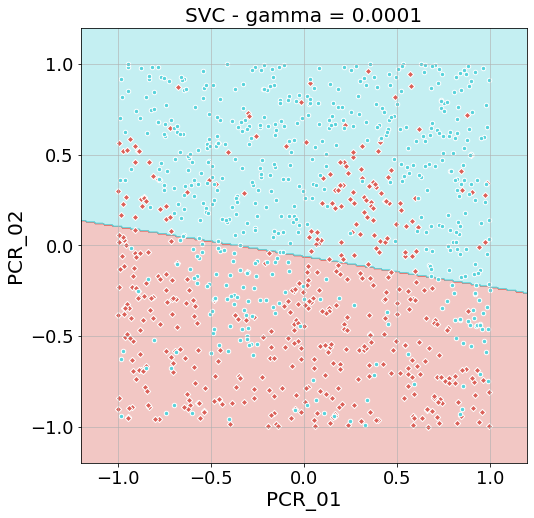

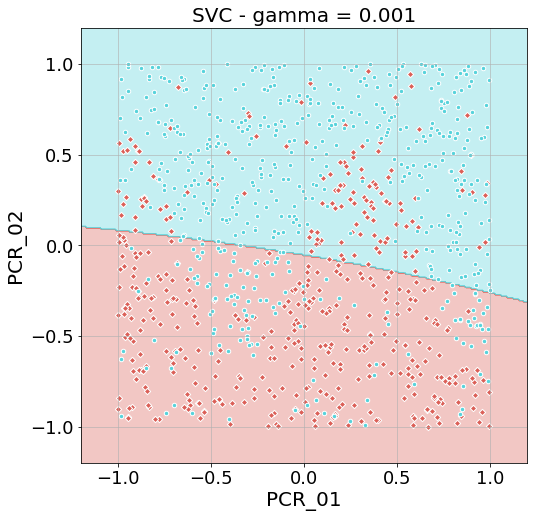

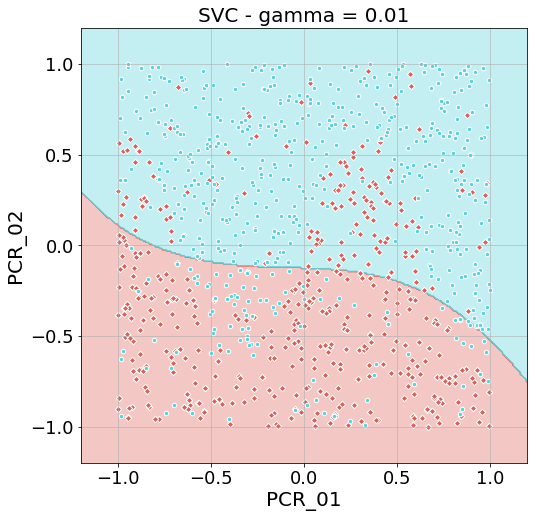

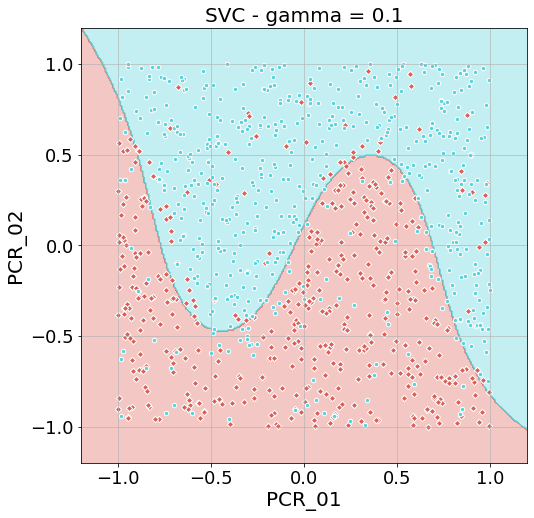

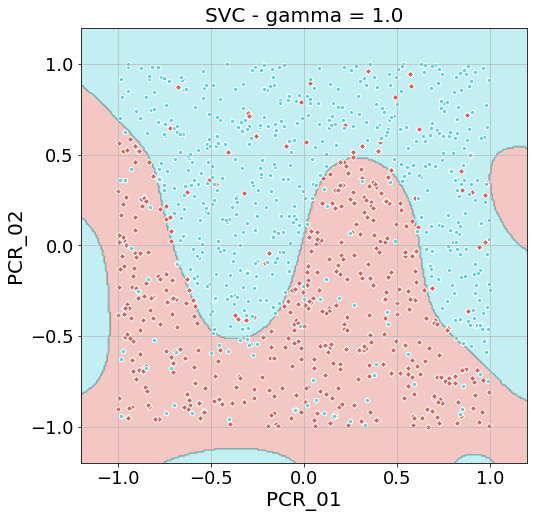

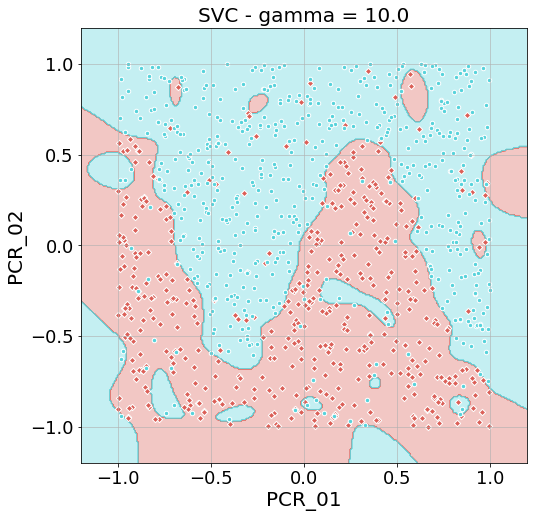

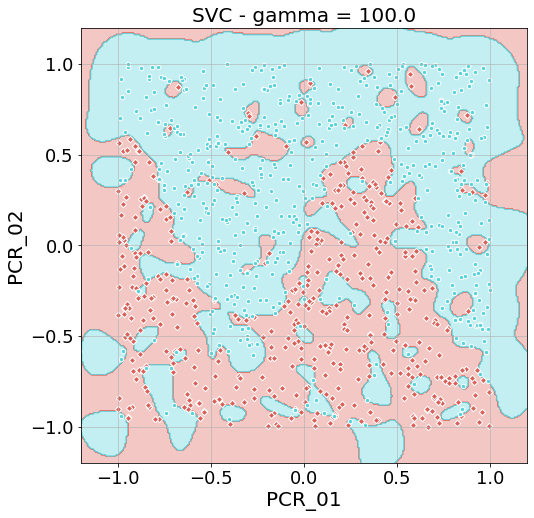

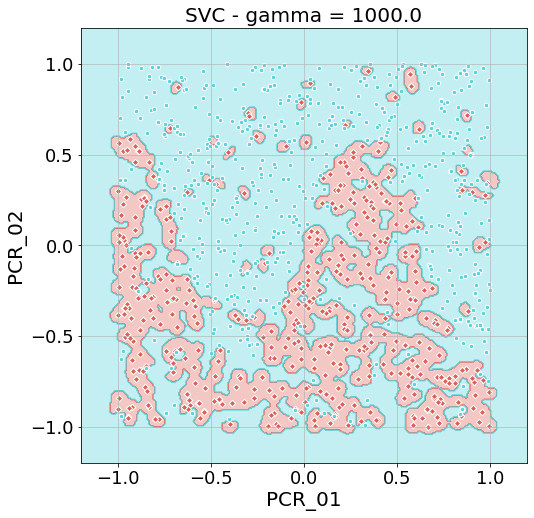

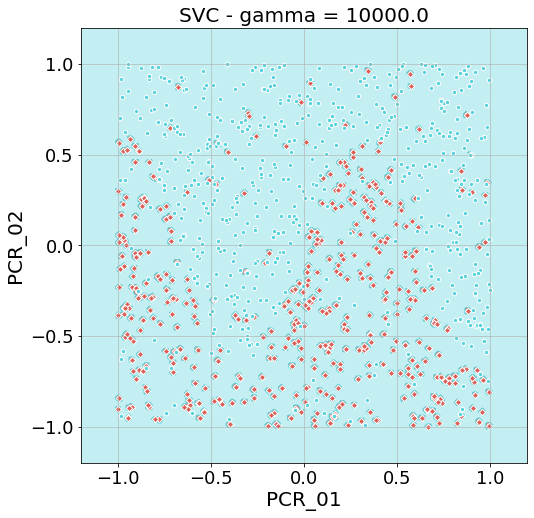

In [82]:
# Q(15)
from sklearn.svm import SVC
for i in np.logspace(-5, 4, 10):
  cls = SVC(kernel='rbf',  C=1e4, gamma=i)
  cls.fit(X_train,y_train, )
  visualize_clf(cls, X_train,y_train, 'SVC - gamma = '+str(i), 'PCR_01','PCR_02',marker_size=20)


In [83]:
# Q(17)
for i in np.logspace(3, 1, 10):
  cls = SVC(C=1e4, gamma=i)
  temp_cv_results = cross_validate(temp_knn, np.array(training_df_all_features),training_df_cleaned['spread'],return_train_score=True , cv=8)


[ 0.01  0.01  0.02  0.03  0.04  0.06  0.09  0.13  0.18  0.26  0.38  0.55
  0.78  1.13  1.62  2.34  3.36  4.83  6.95 10.  ]


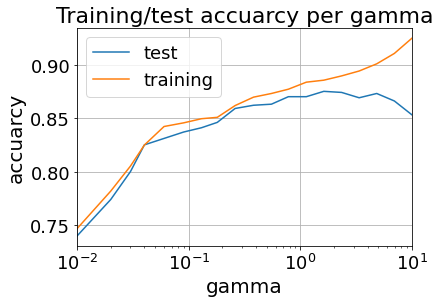

In [84]:
gammas=np.around(np.logspace(-2,1,20),decimals=2)
print(gammas)
parameters = {'gamma':gammas}
cls = SVC(C=1e4)
grid_dt = GridSearchCV(cls, parameters,return_train_score=True,cv=8)
grid_dt.fit(X_train, y_train)

validation_scores = grid_dt.cv_results_['mean_test_score']
training_scores = grid_dt.cv_results_['mean_train_score']
plt.plot(gammas, validation_scores)
plt.plot(gammas,training_scores)
plt.xlim(0.01,10)
plt.xscale('log')
plt.xlabel("gamma")
plt.ylabel("accuarcy")
plt.title("Training/test accuarcy per gamma")
plt.legend(["test",'training'])



plt.grid()


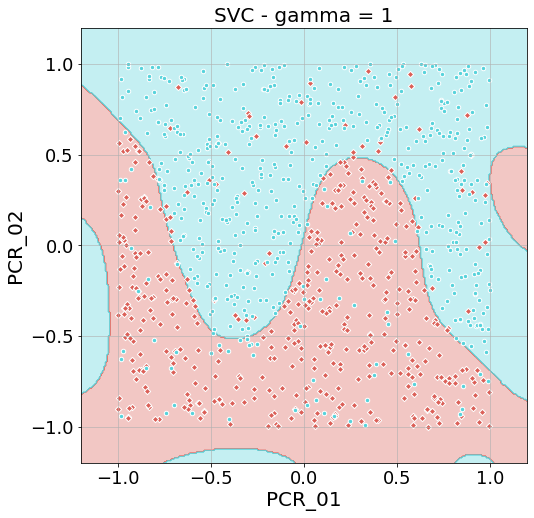

In [85]:
cls = SVC(kernel='rbf',  C=1e4, gamma=1)
cls.fit(X_train,y_train, )
visualize_clf(cls, X_train,y_train, 'SVC - gamma = 1', 'PCR_01','PCR_02',marker_size=20)


In [86]:
cls.score(test_df_cleaned[['PCR_01' , 'PCR_02']],test_df_cleaned['spread'])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


0.868